In [25]:
import shap
import pandas as pd
import numpy as np

from pathlib import Path

from xgboost import XGBClassifier

In [26]:
DATA_PATH = Path('..') / 'data'
RAW_DATA_PATH = DATA_PATH / 'raw'
PROCESSED_DATA_PATH = DATA_PATH / 'processed_v3'

MODELS_PATH = Path('..') / 'models'

# Load Data

In [34]:
X_train = pd.read_csv(PROCESSED_DATA_PATH / 'X_train.csv')
X_val   = pd.read_csv(PROCESSED_DATA_PATH / 'X_val.csv')
y_train = pd.read_csv(PROCESSED_DATA_PATH / 'y_train.csv')
y_val   = pd.read_csv(PROCESSED_DATA_PATH / 'y_val.csv')
X_test  = pd.read_csv(PROCESSED_DATA_PATH / 'X_test.csv')
y_test  = pd.read_csv(PROCESSED_DATA_PATH / 'y_test.csv')

X_train_for_shap = X_train.iloc[:22500,:]
X_test_for_shap = X_test.iloc[:22500,:]

y_pred = np.fromfile(PROCESSED_DATA_PATH / 'y_pred.npy')

# Load XGBoost Model

In [35]:
xgboost_model = XGBClassifier()

xgboost_model.load_model(MODELS_PATH / 'xgboost_model.json')

# Shap Tree Explainer

In [36]:
explainer_train = shap.TreeExplainer(xgboost_model, X_train_for_shap)
explainer_test = shap.TreeExplainer(xgboost_model, X_test_for_shap)

In [37]:
shap_values_train = explainer_train.shap_values(X_train_for_shap)
shap_values_test = explainer_test.shap_values(X_test_for_shap)

100%|===================| 22441/22500 [01:14<00:00]        

# Plot Results

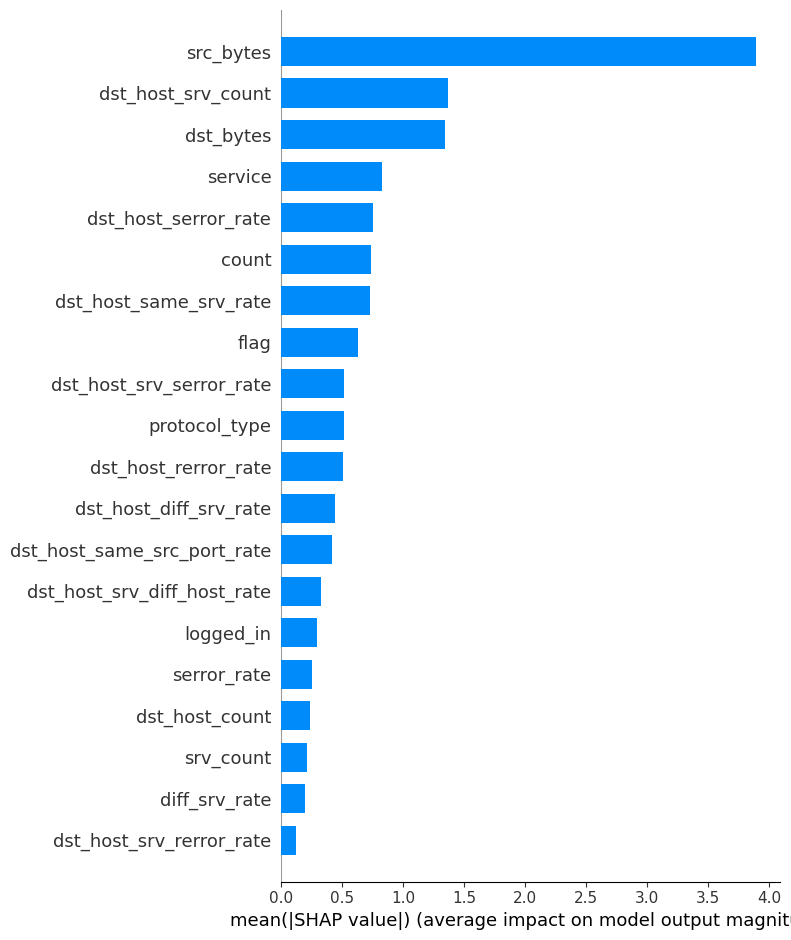

In [38]:
shap.summary_plot(shap_values_train, X_train_for_shap, plot_type='bar')

In [39]:
# get top K shap values by importance
feature_names = X_train_for_shap.columns

rf_resultX = pd.DataFrame(shap_values_train, columns = feature_names)

vals = np.abs(rf_resultX.values).mean(0)

shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
shap_importance.head(20)

,col_name,feature_importance_vals
4,src_bytes,3.891871
32,dst_host_srv_count,1.364898
5,dst_bytes,1.341708
2,service,0.825487
37,dst_host_serror_rate,0.754514
22,count,0.738163
33,dst_host_same_srv_rate,0.730635
3,flag,0.630986
38,dst_host_srv_serror_rate,0.515103
1,protocol_type,0.514827


In [40]:
shap_values_train.tofile(PROCESSED_DATA_PATH / 'shap_values_train_from_xgboost.npy')
shap_values_test.tofile(PROCESSED_DATA_PATH / 'shap_values_test_from_xgboost.npy')